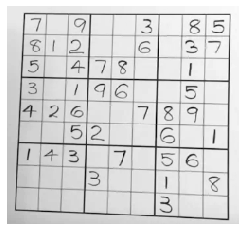

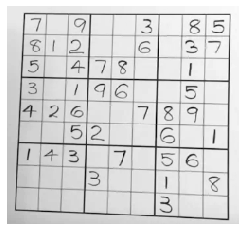

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import imageio

img = imageio.imread('/content/sudoku.PNG',as_gray =True)

# Please attention, in this assignment image is floating point.

def grayConversion(image):
    grayValue = 0.07 * image[:,:,2] + 0.72 * image[:,:,1] + 0.21 * image[:,:,0]
    gray_img = grayValue.astype(np.uint8)
    return gray_img

#gray_image = grayConversion(img)
#gray_image = np.min(gray_image, 255).astype(np.uint8)
img = img.astype('float') / 255.0
# Plot the image.
def display_image(img):
  plt.figure(); plt.imshow(img,cmap='gray'); plt.grid(False);plt.axis('off');plt.show()
  

display_image(img)
#print(img.shape)

#img=np.where(img>0.6,1,0) #Average thresholding would be nice
display_image(img)

In [0]:
import math
from scipy import signal
def gauss_dist(a,b):
  return math.pow((a-7),2)+math.pow((b-7),2)

conv_matrix=np.empty([15,15])

for a in range(15):
  for b in range(15):
    conv_matrix[a][b]=1/2/math.pi/(0.64)*(math.exp(gauss_dist(a,b)/2/0.64*-1))
    
    
blurred_image=signal.convolve2d(img,conv_matrix,mode='same', boundary='fill', fillvalue=0)    

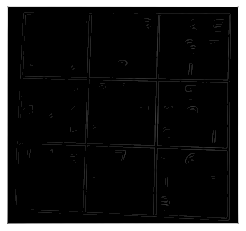

In [5]:
from scipy import signal

sobel_matrix_x=np.array([[1,0,-1], 
                       [2,0,-2], 
                       [1,0,-1]])

sobel_matrix_y=np.array([[1,2,1], 
                       [0,0,0], 
                       [-1,-2,-1]])

img2 = blurred_image

#plt.gray()
#display_image(img2)
Ix=signal.convolve2d(img2,sobel_matrix_x,mode='same', boundary='fill', fillvalue=0)    
Iy=signal.convolve2d(img2,sobel_matrix_y,mode='same', boundary='fill', fillvalue=0)    
Ixx=Ix*Ix
Iyy=Iy*Iy
Ixy=Iy*Ix

# Compute the Rmap and RHarmonicMap map responses.
patch = np.ones((12, 12))
Ixx2=signal.convolve2d(Ixx,patch,mode='same', boundary='fill', fillvalue=0)  
Iyy2=signal.convolve2d(Iyy,patch,mode='same', boundary='fill', fillvalue=0) 
Ixy2=signal.convolve2d(Ixy,patch,mode='same', boundary='fill', fillvalue=0)  
Det=Ixx2*Iyy2-Ixy2*Ixy2
Trace=(Ixx2+Iyy2)

RMap=Det-0.05*Trace**2
RHarmonicMap=Det/(Trace+0.00001)

Mag=Ix**2+Iy**2
Mag=np.where(Mag<1,0,Mag)
#Mag=np.where(Mag>0,0,1)
display_image(Mag)



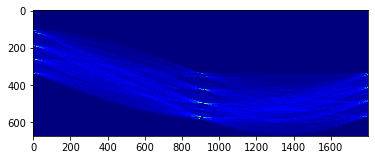

In [6]:

img2 = img

def hough_line(img):
  y = img.shape[0]
  x = img.shape[1]
  thetas = np.deg2rad(np.arange(-90.0, 90.0,0.1))

  diag = np.ceil(np.sqrt(x * x + y * y))   
  rhos = np.linspace(-diag, diag, int(diag * 2.0))

  cos_save = np.cos(thetas)
  sin_save = np.sin(thetas)
  
  diag = diag.astype(int)
 
  votes = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
  ys, xs = np.nonzero(img) 

  
  xs_cos = np.dot(xs.reshape(len(xs),1),np.transpose(cos_save.reshape(len(cos_save),1)))
  ys_sin = np.dot(ys.reshape(len(ys),1),np.transpose(sin_save.reshape(len(sin_save),1)))
  
  rows = np.round(xs_cos + ys_sin + np.ones(xs_cos.shape) * diag).astype(int)
  
  #print(rows.shape)
  #print(votes.shape)
  for i in range(rows.shape[0]):
    for j in range(rows.shape[1]):
      votes[rows[i][j]][j]+=1
    #x = xs[i]
    #y = ys[i]
    
    
    #for a in range(len(thetas)):
      
      #rho = int(round(x * cos_save[a] + y * sin_save[a]) + diag)
      
      #votes[rho, a] = votes[rho, a] + 1

  return votes,diag

hough,diag=hough_line(Mag)

plt.imshow(hough,cmap = 'jet')
plt.show()


(230, 245)


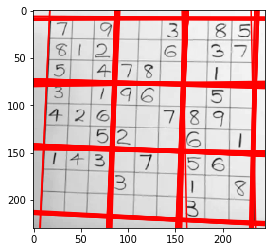

In [7]:
import math

rho_thetas=[]
for a in range(len(hough)):
  for b in range(len(hough[a])):
    if(hough[a,b]>90):
      rho_thetas.append((a-diag,np.deg2rad(b/10)-math.pi/2))
      
      
#rho_thetas = np.argpartition(hough, -15)

      
plt.figure()
plt.imshow(img, cmap='gray')
plt.grid(False)

eqs=[]
print(img.shape)

#print(rho_thetas)# Your code goes here.
for test in rho_thetas:
  #plt.figure()
  #plt.imshow(img, cmap='gray')
  #plt.grid(False)
  slope = -1*math.cos(test[1])/(math.sin(test[1])+0.00000001)
  intercept = test[0]/(math.sin(test[1])+0.0000000001)
  

  axes = plt.gca()
  axes.set_autoscale_on(False)
  x_vals = np.array(axes.get_xlim())
  y_vals = intercept + slope * x_vals
  
  #print(slope)
  #print(intercept)
  #print(test[0],test[1])
  if(abs(slope)<0.1) and (intercept > img.shape[0]-4 or abs(intercept)<3):
    continue
  if(abs(slope)>50) and (abs(abs(slope)-abs(intercept))<5 or abs(intercept)<3 or abs(intercept)>50) :
    continue
  plt.plot(x_vals, y_vals,'r')
  eqs.append((slope, intercept))

plt.show()

In [8]:
left_up = (40000,40000)
left_down = (40000, 0)
right_up = (0, 40000)
right_down = (0,0)


def solve(a_slope, a_int, b_slope, b_int):
  if(not abs(a_slope - b_slope)>10):
    return (False,False)
  x = (b_int-a_int)/(a_slope-b_slope)
  y = (a_slope)* x + a_int
  return (x,y)

for a in eqs:
  for b in eqs:
    if(a[0]==b[0] and a[1]==b[1]):
      continue
    else:
      x,y=solve(a[0],a[1],b[0],b[1])
      #if(a[0]<0.05 and b[0]>5):
        #print(a[0],a[1],b[0], b[1])
        #print(x,y)
      if(not x and  not y):
        continue
        #print(x,y)
      if(x<0 or x > img.shape[1] or y <0 or y > img.shape[0]):
        continue
      if((x+y)<(left_up[0]+left_up[1])):
        left_up = (x,y)
      if((x-y)>(right_up[0]-right_up[1])):
        #print(x,y)
        #print(right_up)
        right_up = (x,y)

      if((x+y)>(right_down[0]+right_down[1])):
        right_down = (x,y)
      if((x-y)<(left_down[0]-left_down[1])):
        left_down = (x,y)
print(left_up, left_down, right_up, right_down)

(16.74240808726599, 6.058478821994749) (7.228097987002446, 215.57981061193584) (237.91234166185936, 6.754392183204119) (234.79691246710564, 226.59886695315072)


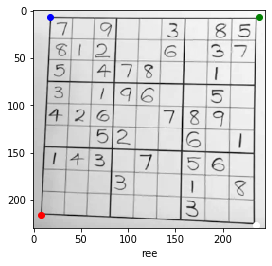

(230, 245)


In [9]:
plt.figure()
plt.imshow(img, cmap='gray')
plt.xlabel("ree")
plt.grid(False)
plt.plot(left_up[0], left_up[1], '.b', markersize=12)
plt.plot(left_down[0], left_down[1], '.r', markersize=12)
plt.plot(right_up[0], right_up[1], '.g', markersize=12)
plt.plot(right_down[0], right_down[1], '.w', markersize=12)
plt.show()
print(img.shape)

Next two cells broken

In [0]:
transformed = np.ones((360, 360),dtype='float')


#plt.imshow(transformed, cmap='gray',vmin=0, vmax=1)

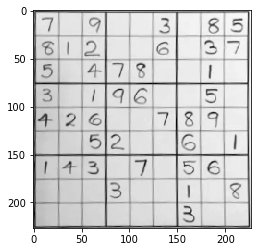

In [38]:
transformed = np.ones((360, 360),dtype='float')


X1,Y1=left_up[0], left_up[1]
X2,Y2=left_down[0], left_down[1]
X3,Y3=right_down[0], right_down[1]
X4,Y4=right_up[0], right_up[1]

def dist(a,b):
  dist1=a[0]-b[0]
  dist2=a[1]-b[1]
  return np.sqrt((dist1 ** 2) + (dist2 ** 2))

def longest(left_up,left_down,right_down,right_up):
  return max(dist(left_up,left_down),dist(left_down,right_down),dist(right_down,right_up),dist(left_up,right_up))


src = np.array([[left_up[0], left_up[1]], [left_down[0], left_down[1]], [right_down[0], right_down[1]], [right_up[0], right_up[1]]], np.float32)

side = longest(left_up,left_down,right_down,right_up)

dst = np.array([[0, 0],[0, side - 1] , [side - 1, side - 1] , [side - 1, 0]], dtype='float32')
x1=0
y1=0
x2=0
y2=side - 1
x3=side - 1
y3=side - 1
x4=side - 1
y4=0


A = [
     [x1,y1,1,0,0,0,-1*X1*x1,-1*X1*y1],
     [0,0,0,x1,y1,1,-1*Y1*x1,-1*Y1*y1],
     [x2,y2,1,0,0,0,-1*X2*x2,-1*X2*y2],
     [0,0,0,x2,y2,1,-1*Y2*x2,-1*Y2*y2],
     [x3,y3,1,0,0,0,-1*X3*x3,-1*X3*y3],
     [0,0,0,x3,y3,1,-1*Y3*x3,-1*Y3*y3],
     [x4,y4,1,0,0,0,-1*X4*x4,-1*X4*y4],
     [0,0,0,x4,y4,1,-1*Y4*x4,-1*Y4*y4],
     ]
A=np.asarray(A)
b=np.asarray(b)
b = [X1,Y1,X2,Y2,X3,Y3,X4,Y4]
res = np.linalg.lstsq(A,b, rcond=None)[0]

a,b,c,d,e,f,g,h=res

i=17
j=6
x=int((a*j+b*i+c)/(g*j+h*i+1))
y=int((d*j+e*i+f)/(g*j+h*i+1))




#print((blurred_image.shape))

for i in range(blurred_image.shape[1]):
  for j in range(blurred_image.shape[0]):
    #print(i,j)
    x=int((a*j+b*i+c)/(g*j+h*i+1))
    y=int((d*j+e*i+f)/(g*j+h*i+1))
    if(x>269 or x<0 or y>269 or y<0):
      continue
    transformed[x,y] = blurred_image[j,i]

plt.imshow(transformed, cmap='gray')

#import cv2 checking

#m = cv2.getPerspectiveTransform(src, dst)
#transformed=cv2.warpPerspective(img, m, (int(side), int(side)))
#plt.imshow(transformed, cmap='gray')

